# Fully Convolutional Watershed Distance Transform for 3D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import sys
sys.path.insert(0,"/home/snn/deepcell-tf")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import deepcell

In [2]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.utils.data_utils import get_file

from deepcell import losses
import image_gen as image_gen
from deepcell import image_generators
from deepcell import model_zoo
from deepcell.layers import TensorProduct, ReflectionPadding3D, DilatedMaxPool3D

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.training import train_model_conv


from tensorflow.python.keras.layers import MaxPool3D
from conv_gru_layer import ConvGRU2D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.layers import Conv3D, ZeroPadding3D, ConvLSTM2D, Cropping3D
from tensorflow.python.keras.layers import Input, Add, Concatenate, Flatten, Reshape
from tensorflow.python.keras.engine.input_layer import InputLayer

from tensorflow.python.keras.models import Model


from tensorflow.python.keras.regularizers import l2
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Softmax

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

### Load the Training Data

In [3]:
# If DATA_FILE exists just run this cell

from deepcell.utils.data_utils import get_data

DATA_DIR = '/data/training_data/tracking_benchmark_data'
DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_cropped.npz')
# DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V2_stacked.npz')

# Load Information for hardcoded image size training
seed = 1
test_size = .2
train_dict, test_dict = get_data(DATA_FILE, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

 -
X.shape: (642, 30, 135, 160, 1)
y.shape: (642, 30, 135, 160, 1)


### Set up filepath constants

In [4]:
# Set up other required filepaths
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)
ROOT_DIR = '/data' # mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

## Define feature net models

#### feature_net_3D is the gru analog of bn_feature_net_3D

In [5]:
def feature_net_3D(receptive_field=61,
                    n_frames=5,
                    input_shape=(5, 256, 256, 1),
                    n_features=3,
                    n_channels=1,
                    reg=1e-5,
                    n_conv_filters=64,
                    n_dense_filters=200,
                    VGG_mode=False,
                    init='he_normal',
                    norm_method='std',
                    location=False,
                    dilated=False,
                    padding=False,
                    padding_mode='reflect',
                    multires=False,
                    include_top=True,
                    temporal=None,
                    temporal_kernel_size=3):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    
    if temporal == "conv":
        win_z = (n_frames - 1) // 2
    else:
        win_z = 0

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    x.append(ImageNormalization3D(norm_method=norm_method,
                                  filter_size=receptive_field)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(win_z, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(win_z, win, win))(x[-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size),
                        dilation_rate=(1, d, d), kernel_initializer=init,
                        padding='valid', kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d),
                                          pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))

    x.append(Conv3D(n_dense_filters, (1, rf_counter, rf_counter),
                    dilation_rate=(1, d, d), kernel_initializer=init,
                    padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))
    
    print("temporal, ", temporal)
    if temporal == "conv":
        x.append(Conv3D(n_dense_filters, (n_frames, 1, 1), dilation_rate=(1, d, d),
                        kernel_initializer=init, padding='valid',
                        kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))
    
    elif temporal == "gru":
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=temporal_kernel_size,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    elif temporal == "lstm":
        x.append(ConvLSTM2D(filters=n_conv_filters, kernel_size=temporal_kernel_size,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    else:
        x.append(Conv3D(n_dense_filters, (1, 1, 1), dilation_rate=(1, d, d),
                        kernel_initializer=init, padding='valid',
                        kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))


    x.append(TensorProduct(n_dense_filters, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_features, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))

    if not dilated:
        x.append(Flatten()(x[-1]))

    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])
    model.summary()
    return model

#### feature_net_skip_3D is the gru analog of bn_feature_net_skip_3D

In [6]:
def feature_net_skip_3D(receptive_field=61,
                        input_shape=(5, 256, 256, 1),
                        fgbg_model=None,
                        temporal=None,
                        temporal_kernel_size=3,
                        last_only=True,
                        n_skips=1,
                        norm_method='whole_image',
                        padding_mode='reflect',
                        **kwargs):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    inputs = Input(shape=input_shape)
    img = ImageNormalization3D(norm_method=norm_method,
                               filter_size=receptive_field)(inputs)

    models = []
    model_outputs = []
    
    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs)
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img

        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(feature_net_3D(receptive_field=receptive_field, 
                                     input_shape=new_input_shape, 
                                     norm_method=None, 
                                     dilated=True, 
                                     padding=True, 
                                     padding_mode=padding_mode, 
                                     temporal=temporal, 
                                     temporal_kernel_size=temporal_kernel_size, 
                                     **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    elif fgbg_model is None:
        model = Model(inputs=inputs, outputs=model_outputs)
    else:
        model = Model(inputs=inputs, outputs=model_outputs[1:])
        
    model.summary()
    return model

#### Test Generator

In [7]:
DataGenerator = image_generators.MovieDataGenerator

datagen = DataGenerator(
    rotation_range=180,
    shear_range=False,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = DataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)


train_data = datagen.flow(
    train_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

val_data = datagen_val.flow(
    test_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

(642, 30, 135, 160, 1)
Image number: 456
Frame number: 8


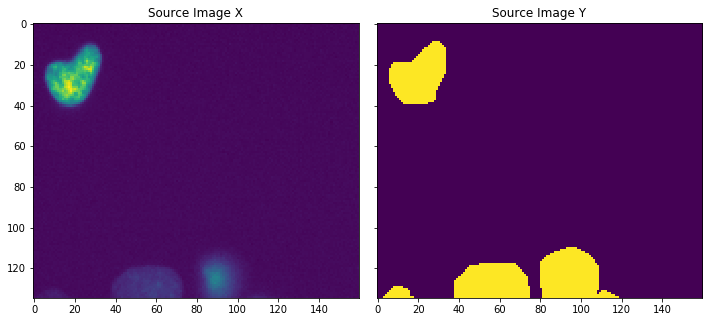

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_data.x.shape)

index = np.random.randint(low=0, high=train_data.x.shape[0])
frame = np.random.randint(low=0, high=train_data.x.shape[1])
print('Image number:', index)
print('Frame number:', frame)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(train_data.x[index, frame, ..., 0])
ax[0].set_title('Source Image X')

ax[1].imshow(train_data.y[index, frame, ..., 1])
ax[1].set_title('Source Image Y')

fig.tight_layout()
plt.show()

## Train the Model

### Training Parameters

In [8]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'trackingSEG_cropped_gru_fgbg_model_5e'
conv_model_name = 'trackingSEG_cropped_gru_watershed_model_5e'

n_epoch = 5  # Number of training epochs
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 0  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance classes
erosion_width = 1  # erode edges, improves segmentation when cells are close

# 3D Settings
frames_per_batch = 3

# Temporal Settings
temporal = "gru"
temporal_kernel_size = 3

### Foreground Background Model

#### (1) Instantiate the fgbg model

In [8]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False,
            norm_method=norm_method)

temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 135, 160, 1)    0         
_________________________________________________________________
image_normalization3d_1 (Ima (None, 3, 135, 160, 1)    0         
_________________________________________________________________
reflection_padding3d (Reflec (None, 3, 195, 220, 1)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 3, 192, 217, 32)   544       
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 192, 217, 32)   128       
_________________________________________________________________
activation (Activation)      (None, 3, 192, 217, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 190, 215, 32)   9248  

In [27]:
fgbg_model.load_weights('/data/models/trackingSEG_cropped_lstm_fgbg_model_5e.h5')

#### (2) Train the fgbg model

In [9]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
        model=fgbg_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=fgbg_model_name,
        log_dir=LOG_DIR,
        transform='fgbg',
        optimizer=optimizer,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
fgbg_model.save_weights(fgbg_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 0.1537 - acc: 0.9373
Epoch 00001: val_loss improved from inf to 0.14790, saving model to /data/models/trackingSEG_cropped_gru_fgbg_model_5e_reset.h5
642/642 [==============================] - 58s 90ms/step - loss: 0.1537 - acc: 0.9373 - val_loss: 0.1479 - val_acc: 0.9535
Epoch 2/5
641/642 [============================>.] - ETA: 0s - loss: 0.1127 - acc: 0.9575
Epoch 00002: val_loss improved from 0.14790 to 0.11661, saving model to /data/models/trackingSEG_cropped_gru_fgbg_model_5e_reset.h5
642/642 [==============================] - 51s 79ms/step - loss: 0.1127 - acc: 0.9575 - val_loss: 0.1166 - val_acc: 0.9648
Epoch 3/5
641/642 [============================>.] - ETA: 0s - loss: 0.1031 - acc: 0.96

### Watershed energy transform

#### (1) Load weights for fgbg model if necessary

In [9]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False,
            )

fgbg_model.load_weights('/data/models/trackingSEG_cropped_gru_fgbg_model_5e.h5')

temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 135, 160, 1)    0         
_________________________________________________________________
image_normalization3d_1 (Ima (None, 3, 135, 160, 1)    0         
_________________________________________________________________
reflection_padding3d (Reflec (None, 3, 195, 220, 1)    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 3, 192, 217, 32)   544       
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 192, 217, 32)   128       
_________________________________________________________________
activation (Activation)      (None, 3, 192, 217, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 190, 215, 32)   9248  

#### (2) Instantiate the distance transform model 

In [10]:
watershed_model = feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,  # (background edge, interior edge, cell interior, background)
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=128,
    temporal=temporal,
    temporal_kernel_size=temporal_kernel_size,
    multires=False,
    last_only=False,
    input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
    norm_method=norm_method)

temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 135, 160, 3)    0         
_________________________________________________________________
image_normalization3d_3 (Ima (None, 3, 135, 160, 3)    0         
_________________________________________________________________
reflection_padding3d_1 (Refl (None, 3, 195, 220, 3)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 3, 192, 217, 32)   1568      
_________________________________________________________________
batch_normalization_9 (Batch (None, 3, 192, 217, 32)   128       
_________________________________________________________________
activation_8 (Activation)    (None, 3, 192, 217, 32)   0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 3, 190, 215, 32)   9248  

In [11]:
# watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_watershed_model.h5')

#### (3) Train the distance transform model

In [12]:
watershed_model = train_model_conv(
        model=watershed_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=conv_model_name,
        test_size=test_size,
        seed=seed,
        transform=transform,
        distance_bins=distance_bins,
        erosion_width=erosion_width,
        optimizer=optimizer,
        batch_size=batch_size,
        n_epoch=n_epoch,
        frames_per_batch=frames_per_batch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

watershed_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_model_name))
watershed_model.save_weights(watershed_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 0.7591 - acc: 0.8531
Epoch 00001: val_loss improved from inf to 0.67817, saving model to /data/models/trackingSEG_cropped_gru_watershed_model_5e.h5
642/642 [==============================] - 74s 116ms/step - loss: 0.7593 - acc: 0.8532 - val_loss: 0.6782 - val_acc: 0.8764
Epoch 2/5
641/642 [============================>.] - ETA: 0s - loss: 0.6687 - acc: 0.8756
Epoch 00002: val_loss improved from 0.67817 to 0.63923, saving model to /data/models/trackingSEG_cropped_gru_watershed_model_5e.h5
642/642 [==============================] - 67s 104ms/step - loss: 0.6688 - acc: 0.8757 - val_loss: 0.6392 - val_acc: 0.8734
Epoch 3/5
641/642 [============================>.] - ETA: 0s - loss: 0.6596 - acc: 0.88

# Run the model

#### Make predictions on test data

In [94]:
temporal = "conv"

raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
trks = load_trks(raw_trks_HEK)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model_5e.h5')

run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(X_test.shape[1:]),
                        norm_method=norm_method,
                        temporal=temporal,
                        temporal_kernel_size=temporal_kernel_size)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_watershed_model_5e.h5')

temporal,  conv
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 30, 135, 160, 1)   0         
_________________________________________________________________
image_normalization3d_64 (Im (None, 30, 135, 160, 1)   0         
_________________________________________________________________
reflection_padding3d_28 (Ref (None, 34, 195, 220, 1)   0         
_________________________________________________________________
conv3d_252 (Conv3D)          (None, 34, 192, 217, 32)  544       
_________________________________________________________________
batch_normalization_288 (Bat (None, 34, 192, 217, 32)  128       
_________________________________________________________________
activation_284 (Activation)  (None, 34, 192, 217, 32)  0         
_________________________________________________________________
conv3d_253 (Conv3D)          (None, 34, 190, 215, 32)  9248 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
image_normalization3d_65 (Image (None, 30, 135, 160, 0           input_66[0][0]                   
__________________________________________________________________________________________________
model_64 (Model)                (None, 30, 135, 160, 213570      input_66[0][0]                   
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 30, 135, 160, 0           image_normalization3d_65[0][0]   
                                                                 model_64[1][0]                   
__________

In [95]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:1, :, :, :, :])# [-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:1, :, :, :, :])# [-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1, 30, 135, 160, 4)
segmentation mask shape: (1, 30, 135, 160, 2)


### Watershed post-processing

In [90]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (1, 30, 135, 160, 1)


In [91]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [92]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

watershed_images = []
perimeter_area_threshold = 2
foreground = argmax_images_post_fgbg > 0
small_objects_threshold = 100

n_movies = argmax_images_post_fgbg.shape[0]
n_frames = argmax_images_post_fgbg.shape[1]

for i in range(n_movies):
    watershed_frames = []
    for j in range(n_frames):
        image = fg_thresh[i,j,...,0]
        semantic = fg_thresh[i,j,...]
        distance = argmax_images_post_fgbg[i,j,...,0]
        
        markers = label(distance == 3)
        labels = watershed(-distance, markers, mask=image)
        watershed_frames.append(labels)
    watershed_images.append(np.stack(watershed_frames, axis=0))

watershed_images = np.stack(watershed_images, axis=0)
watershed_images = np.expand_dims(watershed_images, axis=-1)
# for i in range(argmax_images_post_fgbg.shape[0]):
#     image = fg_thresh[i, ..., 0]
#     semantic = fg_thresh[i]
#     distance = argmax_images_post_fgbg[i, ..., 0]

#     markers = label(distance == 3)
#     local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
#                                 exclude_border=False, indices=False, labels=image)

#     markers = label(local_maxi)
#     labels = watershed(-distance, markers, mask=image)
    
#     watershed_images.append(labels)
    

#     semantic_argmax = argmax_images[i]
    
#     watershed_sub_array = []
#     for i, segments_semantic in enumerate(segments):
#         masks_concat = image[i:i+1]
#         markers_semantic = markers[i]

#         # Remove misshapen watershed cells
#         props = regionprops(segments_semantic)
#         for prop in props:
#             if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
#                 segments_semantic[segments_semantic == prop.label] = 0

#         masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
#                                    semantic.shape[1], semantic.shape[2]))
        
#         for j in range(0, masks_semantic.shape[0] + 1):
#             masks_semantic[j - 1] = segments_semantic == j
            
#         masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
#         # print("masks_concat", masks_concat.shape)
#         label_image = np.sum(masks_concat, axis=0).astype(int)
#         # print("label_image", label_image.shape)
#         # Remove small objects
#         label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
#         # Relabel the label image
#         label_image = label(label_image)
#         # print("label_image", label_image.shape)
#         watershed_sub_array.append(label_image)
#     watershed_images.append(watershed_sub_array)
        
# watershed_images = np.array(watershed_images)
# watershed_images = np.expand_dims(watershed_images, axis=-1)


### Plot the Results

Image number: 0
Frame: 24
(135, 160)


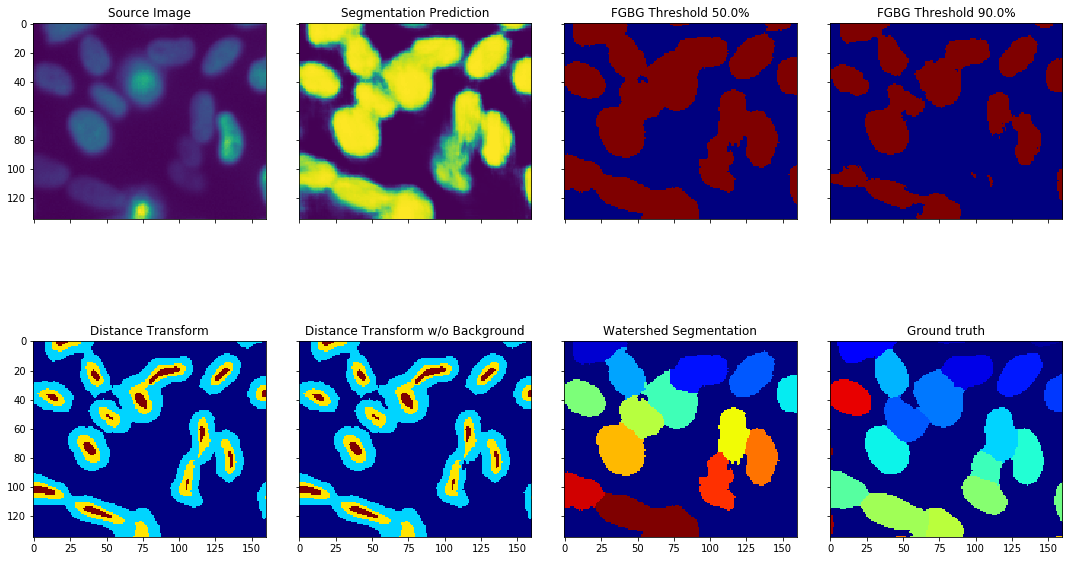

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.random.randint(low=0, high=1)
frame = np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)

print(markers.shape)

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.9
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.9 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Run the Model Iteratively

In [13]:
# Define the Datasets

###### For Deepcell Datasets

# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/training_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

# raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa]
raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa, raw_trks_RAW]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [14]:
# Make predictions on test data
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa']
CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa', 'RAW264']
temporal = "gru"
temporal_kernel_size = 3

perimeter_area_threshold = 2

# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.9
Lstats_AllDatasets = []

# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    
    run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            temporal=temporal,
            temporal_kernel_size=temporal_kernel_size,
            input_shape=tuple(trks['X'].shape[1:]),
            last_only=False,
            norm_method=norm_method)

    run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_gru_fgbg_model_5e.h5')

    run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(trks['X'].shape[1:]),
                        norm_method=norm_method,
                        temporal=temporal,
                        temporal_kernel_size=temporal_kernel_size)

    run_watershed_model.load_weights('/data/models/trackingSEG_cropped_gru_watershed_model_5e.h5')
    
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):
        print("batch_num: ", batch_num)
        Lstats = []
        
        # Predict on the raw data
        X_test_temp = np.expand_dims(movie, axis=0)
        y_test_temp = np.expand_dims(trks['y'][batch_num], axis=0)
        print("X_test_temp.shape", X_test_temp.shape)
        test_images = run_watershed_model.predict(X_test_temp) #[-1]
        test_images_fgbg = run_fgbg_model.predict(X_test_temp) #[-1]
        # 
        # Postprocessing
        # Collapse predictions into semantic segmentation mask
        argmax_images = []
        for frame_num, frame in enumerate(test_images):
            max_image = np.argmax(frame, axis=-1)
            argmax_images.append(max_image)
        argmax_images = np.array(argmax_images)
        argmax_images = np.expand_dims(argmax_images, axis=-1)
        
        # threshold the foreground/background
        # and remove background from watershed transform
        fg_thresh = test_images_fgbg[..., 1] > threshold
        fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
        argmax_images_post_fgbg = argmax_images * fg_thresh
        watershed_images = []
        
        n_movies = argmax_images_post_fgbg.shape[0]
        n_frames = argmax_images_post_fgbg.shape[1]
        
        for i in range(n_movies):
            watershed_frames = []
            for j in range(n_frames):
                image = fg_thresh[i,j,...,0]
                semantic = fg_thresh[i,j,...]
                distance = argmax_images_post_fgbg[i,j,...,0]

                markers = label(distance == 3)
                labels = watershed(-distance, markers, mask=image)
                watershed_frames.append(labels)
            watershed_images.append(np.stack(watershed_frames, axis=0))

        watershed_images = np.stack(watershed_images, axis=0)
        watershed_images = np.expand_dims(watershed_images, axis=-1)

#         for i in range(argmax_images_post_fgbg.shape[0]):
#             image = fg_thresh[i, ..., 0]
#             semantic = fg_thresh[i]
#             distance = argmax_images_post_fgbg[i, ..., 0]

#             local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
#                                         exclude_border=False, indices=False, labels=image)

#             markers = label(local_maxi)
#             segments = watershed(-distance, markers, mask=image)


#             semantic_argmax = argmax_images[i]

#             watershed_sub_array = []
#             for i, segments_semantic in enumerate(segments):
#                 masks_concat = image[i:i+1]
#                 markers_semantic = markers[i]

#                 # Remove misshapen watershed cells
#                 props = regionprops(segments_semantic)
#                 for prop in props:
#                     if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
#                         segments_semantic[segments_semantic == prop.label] = 0

#                 masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
#                                            semantic.shape[1], semantic.shape[2]))

#                 for j in range(0, masks_semantic.shape[0] + 1):
#                     masks_semantic[j - 1] = segments_semantic == j

#                 masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
#                 # print("masks_concat", masks_concat.shape)
#                 label_image = np.sum(masks_concat, axis=0).astype(int)
#                 # print("label_image", label_image.shape)
#                 # Remove small objects
#                 label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
#                 # Relabel the label image
#                 label_image = label(label_image)
#                 # print("label_image", label_image.shape)
#                 watershed_sub_array.append(label_image)
#             watershed_images.append(watershed_sub_array)
#         watershed_images = np.array(watershed_images)
#         watershed_images = np.expand_dims(watershed_images, axis=-1)
        
        print("watershed_images.shape", watershed_images.shape)
        print("y_test_temp.shape", y_test_temp.shape)
        
        # Remove small objects from GT for comparison
        small_objects_threshold=100
        for i in range(watershed_images.shape[0]):
            for j in range(watershed_images.shape[1]):
                # Remove small objects from GT for comparison
                GT_image = y_test_temp[i, j, :, :, :]
                watershed_image = watershed_images[i, j, :, :, :]
                GT_image = np.expand_dims(GT_image, axis=0)
                watershed_image = np.expand_dims(watershed_image, axis=0)
                GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)

                pp_watershed_image = morphology.remove_small_objects(
                                        watershed_image.astype('uint16'), 
                                        min_size=small_objects_threshold)

                # Accuracy from metrics package
                filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(i)

                m = metrics.Metrics(model_name = filename)
                m.calc_object_stats(GT_image, pp_watershed_image)

                Lstats.append(m.stats)
            
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)

df_3T3    = pd.concat([pd.concat(Lstats_AllDatasets[0][i]) for i in range(len(Lstats_AllDatasets[0]))])
df_HEK293 = pd.concat([pd.concat(Lstats_AllDatasets[1][i]) for i in range(len(Lstats_AllDatasets[1]))])
df_HeLa   = pd.concat([pd.concat(Lstats_AllDatasets[2][i]) for i in range(len(Lstats_AllDatasets[2]))])
df_RAW264 = pd.concat([pd.concat(Lstats_AllDatasets[3][i]) for i in range(len(Lstats_AllDatasets[3]))])

temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 30, 154, 182, 1)   0         
_________________________________________________________________
image_normalization3d_5 (Ima (None, 30, 154, 182, 1)   0         
_________________________________________________________________
reflection_padding3d_2 (Refl (None, 30, 214, 242, 1)   0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 30, 211, 239, 32)  544       
_________________________________________________________________
batch_normalization_18 (Batc (None, 30, 211, 239, 32)  128       
_________________________________________________________________
activation_16 (Activation)   (None, 30, 211, 239, 32)  0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 30, 209, 237, 32)  9248  

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 30, 154, 182, 0                                            
__________________________________________________________________________________________________
image_normalization3d_6 (ImageN (None, 30, 154, 182, 0           input_7[0][0]                    
__________________________________________________________________________________________________
model_5 (Model)                 (None, 30, 154, 182, 257186      input_7[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 30, 154, 182, 0           image_normalization3d_6[0][0]    
                                                                 model_5[1][0]                    
__________

/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:801: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['gained_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:804: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['missed_detections'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:807: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['merge'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:810: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['split'].sum() / total_err, self.ndigits)))
/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:813: RuntimeWarning: invalid value encountered in long_scalars
  to_precision(100 * self.stats['catastrophe'].sum() / total_e


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7767361111111110716365146799944341182708740234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  8	Recall: 80%
Incorrect detections: 2	Precision: 80%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from split

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 10

Correct detections:  10	Recall: 76.9230769230769197974950657226145267486572265625%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73956775859725432109570419925148598849773406982421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  11	Recall: 91.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detect


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8983992159425024937036141636781394481658935546875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.885672937771345925028754209051840007305145263671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  4	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75270072992700731706605665749520994722843170166015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84937712344280857923450867019710130989551544189453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  9	Recall: 90%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8323381521055939202824447420425713062286376953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  9	Recall: 90%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Err

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7689504373177842300179918311187066137790679931640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  12	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Ca

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7517425650557620908642775248154066503047943115234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  13	Recall: 9

watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  1	Recall: 16.666666666666667850904559600166976451873779296875%
Incorrect detections: 3	Precision: 25%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 5	Perc Error: 62.5%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.360964138741916518160479654397931881248950958251953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  1	Recall: 16.666666666666667850904559600166976451873779296875%
Incor

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.649245283018867969104803705704398453235626220703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.42857

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8205668774888732475147889999789185822010040283203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.333333333333


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80069524913093859108670358182280324399471282958984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catas

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  4	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5890052356020942792014238875708542764186859130859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  5	Recall: 62.5%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained d


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  1	Recall: 14.2857142857142864755815026001073420047760009765625%
Incorrect detections: 5	Precision: 16.666666666666667850904559600166976451873779296875%

Gained detections: 5	Perc Error: 45.4545454545454532535586622543632984161376953125%
Missed detections: 6	Perc Error: 54.5454545454545467464413377456367015838623046875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.355020491803278714915137470597983337938785552978515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 7

Correct detections:  3	Recall: 33.3333333333333357018091192003339529

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  6	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6444836433611289550071887788362801074981689453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7453175457481162613504466207814402878284454345703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85306269085683494868277421119273640215396881103515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Err

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80114159454980671259960445240722037851810455322265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 50%
Catastrophes: 0		Perc Err


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 7

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79269328802039085157815634374856017529964447021484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8391908459337964476532079061144031584262847900390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  4	Recall: 50%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.4720199310080490651131412960239686071872711181640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  5	Recall: 62.5%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 7

Correct detections:  3	Recall: 33.33333333333333570180911920033395290374755859375%
Incorrect detections: 4	Precision: 42.85714285714285409767398959957063198089599609375%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 4	Perc Error: 50%
Merges: 1		Perc Error: 12.5%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.359206798866855525620422895372030325233936309814453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 6

Correct detections:  3	Recall: 33.33333333333333570180911920033395290374755859375%
Incorrect detections: 3	Precision: 50%

G

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 7

Correct detections:  5	Recall: 41.66666666666666429819088079966604709625244140625%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 1	Perc Error: 14.2857142857142864755815026001073420047760009765625%
Missed detections: 5	Perc Error: 71.4285714285714306015506736002862453460693359375%
Merges: 1		Perc Error: 14.2857142857142864755815026001073420047760009765625%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.413055015036263906136326795603963546454906463623046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of p


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 11

Correct detections:  8	Recall: 80%
Incorrect detections: 3	Precision: 72.7272727272727337322066887281835079193115234375%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7223850171996433200405363095342181622982025146484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precis

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6941923774954628090227970460546202957630157470703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 11

Correct detections:  9	Recall: 90%
Incorrect detections: 2	Precision: 81.8181818181

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73202614379084962603627673161099664866924285888671875 

batch_num:  11
X_test_temp.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
y_test_temp.shape (1, 30, 154, 182, 1)
INFO:tensorflow:0 samples processed

____


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80205348615090732433685616342700086534023284912109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8182879377431906409157136295107193291187286376953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 50%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8554349319774632309787421036162413656711578369140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  9	Recall: 75%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 0	Perc Error: 0%
Missed detections:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8597525044195639676303244414157234132289886474609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	P


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7318252730109204851061122099054045975208282470703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 11

Correct detections:  10	Recall: 100%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73683453237410068137336338622844778001308441162109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.71723352782126081894631397517514415085315704345703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  4	Recall: 80%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.736347197106690831702735522412694990634918212890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  4	Recall: 80%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.63869463869463871663612053453107364475727081298828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc E


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84319927699954810851323827591841109097003936767578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78908188585607941245569918464752845466136932373046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79119226638023631981155858738929964601993560791015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 11

Correct detections:  9	Recall: 90%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.89547768793051807367788796909735538065433502197265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 11

Correct detections:  9	Recall: 90%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 100%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88815486249807962249036563662230037152767181396484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 10

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 2	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.69695204814599109877093496834277175366878509521484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 8

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 2	Precision: 75%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78350287483414415845572875696234405040740966796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastroph


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83971119133574012582954537720070220530033111572265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 1	Perc Error: 33.333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84965202783777293848999079273198731243610382080078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8664395630212615717624657918349839746952056884765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.8571428571


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7174711437565581828579297507531009614467620849609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 8

Correct detections:  6	Recall: 100%
Incorrect detections: 2	Precision: 75%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79952267303102619866450595509377308189868927001953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78864790032302722888601920203655026853084564208984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Ga

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81147429811474303118501438802923075854778289794921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  9	Recall: 75%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80931054802592805597072356249555014073848724365234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 1	Perc Error: 50%
Miss

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7681359044995408336120590320206247270107269287109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections:

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 3	Precision: 57.14285714285714590232601040042936801910400390625%

Gained detections: 3	Perc Error: 60%
Missed detections: 2	Perc Error: 40%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.627006369426751586360069268266670405864715576171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.4285714285714


____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.743028977583378935634073059190995991230010986328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 71.4285714285714306015506736002862453460693359375%

G

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.764204545454545414173708195448853075504302978515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrop

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77685018050541521095198049806640483438968658447265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 9

Correct detections:  7	Recall: 63.63636363636363313389665563590824604034423828125%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 1	Perc Error: 25%
Missed detections: 2	Perc Error: 50%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70506838294448914705725428575533442199230194091796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  9	Recall: 75%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  10	Recall: 90.909090909090906507117324508726596832275390625%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79864903707962053847069228140753693878650665283203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 12

Correct detections:  11	Recall: 100%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gaine

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 30, 135, 160, 1)   0         
_________________________________________________________________
image_normalization3d_8 (Ima (None, 30, 135, 160, 1)   0         
_________________________________________________________________
model_8 (Model)              (None, 30, 135, 160, 2)   257186    
Total params: 257,186
Trainable params: 256,226
Non-trainable params: 960
_________________________________________________________________
temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 30, 135, 160, 3)   0         
_________________________________________________________________
image_normalization3d_11 (Im (None, 30, 135, 160, 3)   0         
_____________________________________________________


____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 3	Precision: 78.5714285714285693984493263997137546539306640625%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 3	Perc Error: 50%
Merges: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74838780194556786540260873152874410152435302734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 14

Correct detections:  11	Recall: 61.111111111111114269078825600445270

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  11	Recall: 64.7058823529411739627903443761169910430908203125%
Incorrect detections: 3	Precision: 78.5714285714285693984493263997137546539306640625%

Gained detections: 2	Perc Error: 28.571428571428572951163005200214684009552001953125%
Missed detections: 4	Perc Error: 57.14285714285714590232601040042936801910400390625%
Merges: 1		Perc Error: 14.2857142857142864755815026001073420047760009765625%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.66264454499748615123877470978186465799808502197265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of p

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 3	Precision: 81.25%

Gained detections: 3	Perc Error: 42.85714285714285409767398959957063198089599609375%
Missed detections: 4	Perc Error: 57.14285714285714590232601040042936801910400390625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70013456163958187605800276287482120096683502197265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  13	Recall: 72.22222222222222853815765120089054107666015

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77891156462585031672318791606812737882137298583984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 15

Correct detections:  12	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 3	Precision: 80%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 3	Perc Error: 50%
Merges: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7869195857092983192870860875700600445270538330078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 16

Correct detections:  11	Recall: 57.894736842105260166135849431157112121582031

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 15

Correct detections:  10	Recall: 50%
Incorrect detections: 5	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 28.571428571428572951163005200214684009552001953125%
Missed detections: 2	Perc Error: 28.571428571428572951163005200214684009552001953125%
Merges: 3		Perc Error: 42.85714285714285409767398959957063198089599609375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 5
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76603557085484796917995709009119309484958648681640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 17

Correct detections:  12	Rec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  15	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75980069568487351716612465679645538330078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 15

Correct detections:  14	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 17

Correct detections:  15	Recall: 88.2352941176470579875967814587056636810302734375%
Incorrect detections: 2	Precision: 88.2352941176470579875967814587056636810302734375%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75271063364169898957101167979999445378780364990234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 1	Precision: 93.333333


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  9	Recall: 75%
Incorrect detections: 3	Precision: 75%

Gained detections: 1	Perc Error: 25%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 25%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.805390032502708574924099593772552907466888427734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  9	Recall: 75%
Incorrect detections: 3	Precision: 75%

Gained detections: 1	Perc Error: 25%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 25%
Catastrophes: 0		Perc Error: 0%

Gained detections from s

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.743500435377534518721631684456951916217803955078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detectio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  14	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7502793296089385055580578409717418253421783447265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  14	Recall: 87.5%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed de


____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.823335246842709533865445337141864001750946044921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 10

Correct detections:  10	Recall: 66.666666666666671403618238400667905807

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7745273377618804300226429404574446380138397216796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 1	Precision: 93.3333333


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90202750602580461514179432924720458686351776123046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  11	Recall: 84.615384615384613198330043815076351165771484375%
Incorrect detections: 1	Precision: 91.6666666666666714036182384006679058074951171875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.85349025974025971574832283295108936727046966552734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 11

Correct detections:  10	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 90.9090909

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80769727495802656758172588524757884442806243896484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Err


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 9

Correct detections:  6	Recall: 60%
Incorrect detections: 3	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73516666666666663498830303069553337991237640380859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 8

Correct detections:  5	Recall: 50%
Incorrect detections: 3	Precision

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 8

Correct detections:  6	Recall: 54.5454545454545467464413377456367015838623046875%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 2		Perc Error: 66.6666666666666714036182384006679058074951171875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.732821987855544865197998660732991993427276611328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  9	Recall: 75%
Incorrect detections: 1	Precision: 90%

Gained d


____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 9

Correct detections:  8	Recall: 72.7272727272727337322066887281835079193115234375%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77018138329679086684365074688685126602649688720703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  7	Recall: 63.63636363636363313389665563590824604034423828125%
Incorrect detections: 3	Precision: 70%

Gained detections: 2	Perc Error: 40%
Missed

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  9	Recall: 64.2857142857142918046520208008587360382080078125%
Incorrect detections: 3	Precision: 75%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 3	Perc Error: 50%
Merges: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75436877347705377783171343253343366086483001708984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 11

Correct detections:  9	Recall: 64.2857142857142918046520208008587360382080078

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  9	Recall: 64.2857142857142918046520208008587360382080078125%
Incorrect detections: 3	Precision: 75%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 3	Perc Error: 50%
Merges: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76874562018220038428495399784878827631473541259765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  9	Recall: 64.2857142857142918046520208008587360382080078


____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 15

Correct detections:  15	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78907833551925599113729958844487555325031280517578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 15

Correct detections:  14	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Misse

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  14	Recall: 87.5%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8137360661632506708684786644880659878253936767578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  14	Recall: 87.5%
Incorrect detections: 1	Precision: 93.33

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  18	Recall: 94.7368421052631646261943387798964977264404296875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81125158027812893646313341378117911517620086669921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  17	Recall: 89.4736842105263150415339623577892780303955078125%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

Gai

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 10

Correct detections:  9	Recall: 64.2857142857142918046520208008587360382080078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 75%
Merges: 1		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79971346704871060229180557143990881741046905517578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 10

Correct detections:  9	Recall: 64.2857142857142918046520208008587360382080078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 0	Perc Error: 0%
Missed detections

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 9

Correct detections:  9	Recall: 69.23076923076922639666008763015270233154296875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 4	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81091070372560614121226763018057681620121002197265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 9

Correct detections:  9	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Sp


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7901332278063579739324495676555670797824859619140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  12	Recall: 80%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.761527830129413274562466540373861789703369140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  12	Recall: 80%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 2	Perc Error: 40%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 12

Correct detections:  10	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 20%
Missed detections: 3	Perc Error: 60%
Merges: 1		Perc Error: 20%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76200256739409499839865702597307972609996795654296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  10	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 2	Precision: 83.33333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 11

Correct detections:  8	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 3	Precision: 72.7272727272727337322066887281835079193115234375%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 60%
Merges: 1		Perc Error: 20%
Splits: 1		Perc Error: 20%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73467941905774003519269399475888349115848541259765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 10

Correct detections:  9	Recall: 69.23076923076922639666008763015270233154296875%
Incorrect detections: 1	Precision: 90%

Gained

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  9	Recall: 75%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74786432160804017232891283128992654383182525634765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  9	Recall: 7

watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  12	Recall: 92.3076923076923065991650219075381755828857421875%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82547235829251219829671981642604805529117584228515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 12

Correct detections:  12	Recall: 85.714285714

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  11	Recall: 78.5714285714285693984493263997137546539306640625%
Incorrect detections: 2	Precision: 84.615384615384613198330043815076351165771484375%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7696953429069923746652648333110846579074859619140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  11	Recall: 78

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  11	Recall: 73.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 84.615384615384613198330043815076351165771484375%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.71469065812176479912665172378183342516422271728515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  10	Recall: 6

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  15	Recall: 93.75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78409235062793347648124608895159326493740081787109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  12	Recall: 70.588235294117652074419311247766017913818359375%
Incorrect detections: 3	Precision: 80%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 5	Perc Error: 62.5%
Merges: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 17

Correct detections:  14	Recall: 73.6842105263157947092622634954750537872314453125%
Incorrect detections: 3	Precision: 82.3529411764705940868225297890603542327880859375%

Gained detections: 1	Perc Error: 25%
Missed detections: 1	Perc Error: 25%
Merges: 2		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78262851932064292359569890322745777666568756103515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 17

Correct detections:  14	Recall: 73.6842105263157947092622634954750537872314453125%
Incorrect detections: 3	Precision: 82.35294

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 19

Correct detections:  16	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 3	Precision: 84.2105263157894796677283011376857757568359375%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7823303457106274283461289087426848709583282470703125 

batch_num:  14
X_test_temp.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  13	Recall: 81.25%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80620630442781793245643484624451957643032073974609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 13

Correct detections:  12	Recall: 75%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 1	Perc Error: 20%
Missed detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75970292285577378788019586863811127841472625732421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  13	Recall: 7

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 15

Correct detections:  8	Recall: 44.4444444444444428654605871997773647308349609375%
Incorrect detections: 7	Precision: 53.33333333333333570180911920033395290374755859375%

Gained detections: 3	Perc Error: 27.27272727272727337322066887281835079193115234375%
Missed detections: 5	Perc Error: 45.4545454545454532535586622543632984161376953125%
Merges: 2		Perc Error: 18.181818181818183433051672182045876979827880859375%
Splits: 1		Perc Error: 9.0909090909090917165258360910229384899139404296875%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70193285859613430144321455372846685349941253662109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics_____

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  7	Recall: 41.17647058823529704341126489453017711639404296875%
Incorrect detections: 7	Precision: 50%

Gained detections: 2	Perc Error: 25%
Missed detections: 2	Perc Error: 25%
Merges: 3		Perc Error: 37.5%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 12.5%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 2
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.70881342227612698092542586891795508563518524169921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 12

Correct detections:  6	Recall: 33.33333333333333570180911920033395290374755859375%
Incorrect detections: 6	Precision: 50%

Gained detections: 1	Perc Error: 12.5%
Missed

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 18

Correct detections:  13	Recall: 59.090909090909093492882675491273403167724609375%
Incorrect detections: 5	Precision: 72.22222222222222853815765120089054107666015625%

Gained detections: 3	Perc Error: 30%
Missed detections: 5	Perc Error: 50%
Merges: 2		Perc Error: 20%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.645584616786658127551845609559677541255950927734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 16

Correct detections:  11	Recall: 52.380952380952379598966217599809169769287109375%
Incorrect detections: 5	Precision: 68.75%

Gained

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  11	Recall: 61.111111111111114269078825600445270538330078125%
Incorrect detections: 5	Precision: 68.75%

Gained detections: 4	Perc Error: 40%
Missed detections: 5	Perc Error: 50%
Merges: 1		Perc Error: 10%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7451542608097259101640474909800104796886444091796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  11	Recall: 61.111111111111114269078825600445270538330078125%
Incorrect detections: 6	Precision: 64.7058823529411739627903443761169910430908203125%

Gai

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 3	Precision: 81.25%

Gained detections: 2	Perc Error: 40%
Missed detections: 2	Perc Error: 40%
Merges: 1		Perc Error: 20%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79623708804722082010840722432476468384265899658203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  12	Recall: 70.588235294117652074419311247766017913818359375%
Incorrect detections: 4	Precision: 75%

Gained detections: 3	Perc Error: 42.8571428571428

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 13

Correct detections:  11	Recall: 68.75%
Incorrect detections: 2	Precision: 84.615384615384613198330043815076351165771484375%

Gained detections: 1	Perc Error: 20%
Missed detections: 3	Perc Error: 60%
Merges: 1		Perc Error: 20%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.68392689784442362022076622452004812657833099365234375 

batch_num:  17
X_test_temp.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
y_test_temp.shape (1, 30, 135, 160, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  12	Recall: 70

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 13

Correct detections:  10	Recall: 62.5%
Incorrect detections: 3	Precision: 76.9230769230769197974950657226145267486572265625%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 3		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.81974352770384706357020832001580856740474700927734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 13

Correct detections:  10	Recall: 58.82352941176470295658873510546982288360595703125%
Incorrect detections: 3	Precision: 76.9230769230769197974950657226145267486572265625%

G

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 16

Correct detections:  12	Recall: 60%
Incorrect detections: 4	Precision: 75%

Gained detections: 1	Perc Error: 16.666666666666667850904559600166976451873779296875%
Missed detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 3		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 3
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7408759124087591629859161912463605403900146484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 18

Correct detections:  14	Recall: 70%
Incorrect detections: 4	Precision: 77.77777777777777146184234879910945892333984375%

Gained


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  14	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84999287038357340673400130981463007628917694091796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Cata

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8155708855413206226359079664689488708972930908203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 13

Correct detections:  12	Recall: 75%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 0	Perc Error: 0%
Missed detectio

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 2	Precision: 87.5%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74965176649360520944043173585669137537479400634765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 16

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 2	Precision: 87.5%

Gained detections: 1	Perc Error: 33.33333333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7848967551622418881152043468318879604339599609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 15

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.3333333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 13

Correct detections:  11	Recall: 68.75%
Incorrect detections: 2	Precision: 84.615384615384613198330043815076351165771484375%

Gained detections: 2	Perc Error: 28.571428571428572951163005200214684009552001953125%
Missed detections: 5	Perc Error: 71.4285714285714306015506736002862453460693359375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.72077840552416827524240261482191272079944610595703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.71428571428570819534797919914126396179199


____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82582626498976308138111335210851393640041351318359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.307692307692306599165021907538175582885742

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  13	Recall: 81.25%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171875%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80504556861709153370298963636741973459720611572265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  12	Recall: 75%
Incorrect detections: 2	Precision: 85.71


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83819138347788990639486428335658274590969085693359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 13

Correct detections:  12	Recall: 80%
Incorrect detections: 1	Precision

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.3076923076923065991650219075381755828857421875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8292410714285713968507707249955274164676666259765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 12

Correct detections:  10	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 83.3333333

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 12

Correct detections:  9	Recall: 50%
Incorrect detections: 3	Precision: 75%

Gained detections: 1	Perc Error: 12.5%
Missed detections: 5	Perc Error: 62.5%
Merges: 2		Perc Error: 25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.752468347078638633007585667655803263187408447265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 14

Correct detections:  10	Recall: 55.5555555555555571345394128002226352691650390625%
Incorrect detections: 4	Precision: 71.4285714285714306015506736002862453460693359375%

Gained detections: 2	Perc Error: 25%
Missed detec

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  12	Recall: 75%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80125078173858665930850975200883112847805023193359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 14

Correct detections:  12	Recall: 70.58823529411765207441931124776601791381835937

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 2	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 1	Perc Error: 50%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.848246991104133929439967687358148396015167236328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  14	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detect

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83459018420076647171157446791767142713069915771484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 14

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 1	Precision: 92.857142857

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 8

Correct detections:  6	Recall: 54.5454545454545467464413377456367015838623046875%
Incorrect detections: 2	Precision: 75%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 2		Perc Error: 66.6666666666666714036182384006679058074951171875%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 2
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79087261785356066656760276600834913551807403564453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 9

Correct detections:  5	Recall: 45.4545454545454532535586622543632984161376953125%


INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  6	Recall: 50%
Incorrect detections: 4	Precision: 60%

Gained detections: 1	Perc Error: 16.666666666666667850904559600166976451873779296875%
Missed detections: 3	Perc Error: 50%
Merges: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%
Splits: 1		Perc Error: 16.666666666666667850904559600166976451873779296875%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6795329224781057053661470490624196827411651611328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 9

Correct detections:  6	Recall: 50%
Incorrect detections: 3	Precision: 66.66

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  6	Recall: 50%
Incorrect detections: 4	Precision: 60%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 4	Perc Error: 50%
Merges: 1		Perc Error: 12.5%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.69303699098539006673291851257090456783771514892578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 10

Correct detections:  6	Recall: 46.15384615384615329958251095376908779144287109375%
Incorrect detections: 4	Precision: 60%

Gained detections: 3	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  13	Recall: 86.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79045470734892553377193280539358966052532196044921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  12	Recall: 7

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  13	Recall: 76.470588235294115975193562917411327362060546875%
Incorrect detections: 2	Precision: 86.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74714537963507943185703652488882653415203094482421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  12	Recall: 7


____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 18

Correct detections:  14	Recall: 70%
Incorrect detections: 4	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 4	Perc Error: 40%
Missed detections: 6	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7553324968632371128052227504667825996875762939453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 15

Correct detections:  12	Recall: 63.15789473684210264536886825226247310638427734375%
Incorrect detections: 3	Precision: 80%

Gained detections: 2	Perc Error: 25%
Missed detections: 5	Perc Error: 62.5%
Merges: 1		Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 16

Correct detections:  10	Recall: 45.4545454545454532535586622543632984161376953125%
Incorrect detections: 6	Precision: 62.5%

Gained detections: 5	Perc Error: 31.25%
Missed detections: 10	Perc Error: 62.5%
Merges: 1		Perc Error: 6.25%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.59135230966216878467633932814351283013820648193359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 18

Correct detections:  12	Recall: 54.5454545454545467464413377456367015838623046875%
Incorrect detections: 6	Precision: 66.666666666666671403618238400667905807495117

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 22
Number of predicted cells:	 15

Correct detections:  11	Recall: 50%
Incorrect detections: 4	Precision: 73.3333333333333285963817615993320941925048828125%

Gained detections: 3	Perc Error: 23.076923076923076649791255476884543895721435546875%
Missed detections: 9	Perc Error: 69.23076923076922639666008763015270233154296875%
Merges: 1		Perc Error: 7.69230769230769251265655839233659207820892333984375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.56856124554492593059507044017664156854152679443359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 16

Correct detections:  13	Recal

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 40, 216, 256, 1)   0         
_________________________________________________________________
image_normalization3d_12 (Im (None, 40, 216, 256, 1)   0         
_________________________________________________________________
model_12 (Model)             (None, 40, 216, 256, 2)   257186    
Total params: 257,186
Trainable params: 256,226
Non-trainable params: 960
_________________________________________________________________
temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 40, 216, 256, 3)   0         
_________________________________________________________________
image_normalization3d_15 (Im (None, 40, 216, 256, 3)   0         
_____________________________________________________


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 4

Correct detections:  2	Recall: 22.22222222222222143273029359988868236541748046875%
Incorrect detections: 2	Precision: 50%

Gained detections: 2	Perc Error: 22.22222222222222143273029359988868236541748046875%
Missed detections: 7	Perc Error: 77.77777777777777146184234879910945892333984375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.31091964787413373105806613239110447466373443603515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 4

Correct detections:  2	Recall: 22.22222222222222143273029359988868236541748046875%
Incorrect detections: 2	Precision: 50%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 4

Correct detections:  2	Recall: 25%
Incorrect detections: 2	Precision: 50%

Gained detections: 2	Perc Error: 25%
Missed detections: 6	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.339108429044189196854830470329034142196178436279296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 4

Correct detections:  2	Recall: 25%
Incorrect detections: 2	Precision: 50%

Gained detections: 2	Perc Error: 25%
Missed detections: 6	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Er

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 4

Correct detections:  2	Recall: 25%
Incorrect detections: 2	Precision: 50%

Gained detections: 2	Perc Error: 25%
Missed detections: 6	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.345591142744167634237584252332453615963459014892578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 4

Correct detections:  2	Recall: 25%
Incorrect detections: 2	Precision: 50%

Gained detections: 2	Perc Error: 25%
Missed detections: 6	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Er

watershed_images.shape (1, 40, 216, 256, 1)
y_test_temp.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 6

Correct detections:  5	Recall: 45.4545454545454532535586622543632984161376953125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 14.2857142857142864755815026001073420047760009765625%
Missed detections: 6	Perc Error: 85.7142857142857081953479791991412639617919921875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.335917611663966664270475348530453629791736602783203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 12

Correct detections:  7	Recall: 58.33333333333333570180911920033395290374755859375%
Incorrect detections: 5	Precision: 58.33333333333333570180911920033395290374755859375%

Gained detections: 3	Perc Error: 37.5%
Missed detections: 4	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 12.5%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5362728062554300567654763653990812599658966064453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  7	Recall: 58.33333333333333570180911920033395290374755859375%
Incorrect detections: 4	Precision: 63.6

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  4	Recall: 33.33333333333333570180911920033395290374755859375%
Incorrect detections: 6	Precision: 40%

Gained detections: 6	Perc Error: 42.85714285714285409767398959957063198089599609375%
Missed detections: 8	Perc Error: 57.14285714285714590232601040042936801910400390625%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.432164948453608255274360772091313265264034271240234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 11

Correct detections:  5	Recall: 38.4615384615384598987475328613072633743286132

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  5	Recall: 38.46153846153845989874753286130726337432861328125%
Incorrect detections: 7	Precision: 41.66666666666666429819088079966604709625244140625%

Gained detections: 7	Perc Error: 46.66666666666666429819088079966604709625244140625%
Missed detections: 8	Perc Error: 53.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5237176231589639741059727384708821773529052734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 12

Correct detections:  6	Recall: 46.

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.726934849147354622544980884413234889507293701171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  5	Recall: 62.5%
In

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  6	Recall: 75%
Incorrect detections: 1	Precision: 85.7142857142857081953479791991412639617919921875%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.798584298584298579726237221620976924896240234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  7	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  6	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.801605504587155959228539359173737466335296630859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  6	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Err


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76750536376048372755320770011167041957378387451171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7361545538178473346846431013545952737331390380859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.69356208595209789535829258966259658336639404296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Per


____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 8

Correct detections:  8	Recall: 53.33333333333333570180911920033395290374755859375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 7	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.401550726220377851571896599125466309487819671630859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 9

Correct detections:  8	Recall: 53.33333333333333570180911920033395290374755859375%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 12.5%
Mi

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 9

Correct detections:  8	Recall: 50%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 11.111111111111110716365146799944341182708740234375%
Missed detections: 8	Perc Error: 88.888888888888885730921174399554729461669921875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.39626704953338121040218311463831923902034759521484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 9

Correct detections:  8	Recall: 47.05882352941176804961287416517734527587890625%
Inc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 9

Correct detections:  8	Recall: 47.05882352941176804961287416517734527587890625%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 10%
Missed detections: 9	Perc Error: 90%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.368713973365136171711498036529519595205783843994140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 8

Correct detections:  7	Recall: 41.17647058823529704341126489453017711639404296875%
Incorrect detections: 1	Precision: 87.5%

Gained 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 9

Correct detections:  7	Recall: 41.17647058823529704341126489453017711639404296875%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 2	Perc Error: 16.666666666666667850904559600166976451873779296875%
Missed detections: 10	Perc Error: 83.3333333333333285963817615993320941925048828125%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.412539569079955092956168982709641568362712860107421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 10

Correct detections:  7	Recall: 3

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 3

Correct detections:  3	Recall: 60%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.738468049090139633250373663031496107578277587890625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 3

Correct detections:  3	Recall: 60%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Err

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8487133984028394362297831321484409272670745849609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82557651991614255937435018495307303965091705322265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 3

Correct detections:  3	Recall: 75%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc E

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6825889164598841762909842145745642483234405517578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  7	Recall: 87.5%
Incorrect detections: 1	Precision: 87.5%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.688414889167712207296290216618217527866363525390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.67379006913890637786579418389010243117809295654296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  6	Recall: 75%
Incorrect detections: 2	Precision: 75%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Err

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 13

Correct detections:  10	Recall: 55.5555555555555571345394128002226352691650390625%
Incorrect detections: 3	Precision: 76.9230769230769197974950657226145267486572265625%

Gained detections: 3	Perc Error: 27.27272727272727337322066887281835079193115234375%
Missed detections: 8	Perc Error: 72.7272727272727337322066887281835079193115234375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5184215121354984745494220987893640995025634765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 13

Correct detections:  11	Recall: 57.8

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 16

Correct detections:  9	Recall: 47.36842105263158231309716938994824886322021484375%
Incorrect detections: 7	Precision: 56.25%

Gained detections: 5	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 9	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 6.66666666666666696272613990004174411296844482421875%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.54137702747434623962163868782226927578449249267578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 16

Correct detections:  9	Recall: 47.36842105263158231309716938994824886322

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  10	Recall: 52.63157894736841768690283061005175113677978515625%
Incorrect detections: 8	Precision: 55.5555555555555571345394128002226352691650390625%

Gained detections: 6	Perc Error: 40%
Missed detections: 8	Perc Error: 53.33333333333333570180911920033395290374755859375%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 6.66666666666666696272613990004174411296844482421875%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.521005703269338926730824823607690632343292236328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 18

Correct detections:  9	Recall

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 17

Correct detections:  12	Recall: 60%
Incorrect detections: 5	Precision: 70.588235294117652074419311247766017913818359375%

Gained detections: 5	Perc Error: 38.46153846153845989874753286130726337432861328125%
Missed detections: 8	Perc Error: 61.53846153846154010125246713869273662567138671875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.55348649738008870446748233007383532822132110595703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 18

Correct detections:  10	Recall: 50%
Incorrect detections: 8	Precision: 55.55555


____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.788541666666666696272613990004174411296844482421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83583690987124459326196301844902336597442626953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastroph

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84431137724550897605269028645125217735767364501953125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74143859166552050776743953974801115691661834716796875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 10

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
In

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.74654439128123339930453994384151883423328399658203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76735785953177260143576177142676897346973419189453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  9	Recall: 90%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  6	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8178543864162592935684870099066756665706634521484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 6

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  4	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 1	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.852543622511673593322711894870735704898834228515625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  4	Recall: 57.14285714285714590232601040042936801910400390625%
Incorrect detections: 1	Precision: 80%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  3	Recall: 50%
Incorrect detections: 2	Precision: 60%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Merges: 1		Perc Error: 33.33333333333333570180911920033395290374755859375%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7990976015198290038910045041120611131191253662109375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  3	Recall: 42.85714285714285409767398959957063198089599609375%

watershed_images.shape (1, 40, 216, 256, 1)
y_test_temp.shape (1, 40, 216, 256, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  5	Recall: 62.5%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5273049645390071038519863577676005661487579345703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 6

Correct detections:  5	Recall: 62.5%
Incorrect detections: 1	Precision: 83.33333333333332859638

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.56750375617085213608703497811802662909030914306640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.60257195345988978640860977975535206496715545654296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.58060678167757284739991519018076360225677490234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 5

Correct detections:  5	Recall: 71.4285714285714306015506736002862453460693359375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.55842757135164244886027518077753484249114990234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	P

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.61114476075105994556935229411465115845203399658203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 2

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6409295352323838290686808250029571354389190673828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  2	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 1	Precision: 66.6666666666666714036182384006679058074951171875%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7032235459004905209212665795348584651947021484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  3	Recall: 75%
Incorrect detections: 1	Precision: 75%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.76376230404666423101645023052697069942951202392578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  2	Recall: 40%
Incorrect detections: 3	Precision: 40%

Gained detections: 3	Perc Error: 50%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5714285714285713968507707249955274164676666259765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  2	Recall: 40%
Incorrect detections: 3	Precision: 40%

Gained detections: 3	Perc Error: 50%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Erro


____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7878315132605304693669268090161494910717010498046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.777041942604856483711728287744335830211639404296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrop

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.86127167630057799296849907477735541760921478271484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 3
Number of predicted cells:	 3

Correct detections:  3	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr


____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  8	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 80%

Gained detections: 2	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 4	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6613722171592240073323409887962043285369873046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  9	Recall: 75%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 25%
Missed d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 9

Correct detections:  7	Recall: 58.33333333333333570180911920033395290374755859375%
Incorrect detections: 2	Precision: 77.77777777777777146184234879910945892333984375%

Gained detections: 2	Perc Error: 28.571428571428572951163005200214684009552001953125%
Missed detections: 5	Perc Error: 71.4285714285714306015506736002862453460693359375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.47835723598435464509748271666467189788818359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 9

Correct detections:  5	Recall: 41.6666666

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  11	Recall: 78.5714285714285693984493263997137546539306640625%
Incorrect detections: 2	Precision: 84.615384615384613198330043815076351165771484375%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.661770061915746055092313326895236968994140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  12	Recall: 85.7142857142857081953479791991412639617919921875%
Incorrect detections: 1	Precision: 92.307692307692306


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  3	Recall: 50%
Incorrect detections: 2	Precision: 60%

Gained detections: 2	Perc Error: 40%
Missed detections: 3	Perc Error: 60%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5246506722910624365141529779066331684589385986328125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  3	Recall: 50%
Incorrect detections: 3	Precision: 50%

Gained detections: 3	Perc Error: 50%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.61870155038759688803651215494028292596340179443359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 66.666666666666

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 2	Precision: 66.6666666666666714036182384006679058074951171875%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.6814848762603116227865029941312968730926513671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 7

Correct detections:  4	Recall: 66.6666666666666714036182384006679058074951171875%
Incorrect detections: 3	Precision: 57.1428571428571459

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  3	Recall: 50%
Incorrect detections: 3	Precision: 50%

Gained detections: 3	Perc Error: 50%
Missed detections: 3	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.55458205067487564843276004467043094336986541748046875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 4

Correct detections:  3	Recall: 50%
Incorrect detections: 1	Precision: 75%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Err


____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 2

Correct detections:  2	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8583162217659137116498868635972030460834503173828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 2
Number of predicted cells:	 1

Correct detections:  1	Recall: 50%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections 


____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.850867052023121406278960421332158148288726806640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.88257107540173052040444190424750559031963348388671875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 1
Number of predicted cells:	 1

Correct detections:  1	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

temporal,  gru
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 30, 202, 240, 3)   0         
_________________________________________________________________
image_normalization3d_19 (Im (None, 30, 202, 240, 3)   0         
_________________________________________________________________
reflection_padding3d_9 (Refl (None, 30, 262, 300, 3)   0         
_________________________________________________________________
conv3d_63 (Conv3D)           (None, 30, 259, 297, 32)  1568      
_________________________________________________________________
batch_normalization_81 (Batc (None, 30, 259, 297, 32)  128       
_________________________________________________________________
activation_72 (Activation)   (None, 30, 259, 297, 32)  0         
_________________________________________________________________
conv3d_64 (Conv3D)           (None, 30, 257, 295, 32)  9248  


____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 7

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73998822143698472775241725685191340744495391845703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 7

Correct detections:  7	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 7

Correct detections:  7	Recall: 77.77777777777777146184234879910945892333984375%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7488537952114111551082942241919226944446563720703125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 8

Correct detections:  8	Recall: 88.888888888888885730921174399554729461669921875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Pe

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  10	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8097494922139472084410272145760245621204376220703125 

batch_num:  1
X_test_temp.shape (1, 30, 202, 240, 1)
watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 25
Number of predicted cells:	 24

Correct detections:  23	Recall: 92%
Incorrect detections: 1	Precision: 95.83

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 23

Correct detections:  23	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.78621647426438678873950038905604742467403411865234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 23
Number of predicted cells:	 23

Correct detections:  23	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
C

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 28
Number of predicted cells:	 26

Correct detections:  25	Recall: 89.2857142857142918046520208008587360382080078125%
Incorrect detections: 1	Precision: 96.153846153846160405009868554770946502685546875%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73394495412844040771460640826262533664703369140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 29
Number of predicted cells:	 25

Correct detections:  23	Recall: 79.3103448275862064065222511999309062957763671875%
Incorrect detections: 2	Precision: 92%

Gained d

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 15

Correct detections:  14	Recall: 87.5%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Gained detections: 0	Perc Error: 0%
Missed detections: 0	Perc Error: 0%
Merges: 1		Perc Error: 100%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.71654639827826305253921645999071188271045684814453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 15

Correct detections:  14	Recall: 82.3529411764705940868225297890603542327880859375%
Incorrect detections: 1	Precision: 93.3333333333333285963817615993320941925048828125%

Ga


____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  13	Recall: 81.25%
Incorrect detections: 1	Precision: 92.857142857142861203101347200572490692138671875%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 50%
Merges: 1		Perc Error: 50%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7334532836396350230501184341846965253353118896484375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 16
Number of predicted cells:	 14

Correct detections:  14	Recall: 87.5%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Cata

Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75942652329749105177825185819528996944427490234375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 13
Number of predicted cells:	 13

Correct detections:  13	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75095568455330596879804261334356851875782012939453125 

INFO:tensorflo


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79036458333333337034076748750521801412105560302734375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained d


____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  5	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80482204362801379460279349586926400661468505859375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catast

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 14
Number of predicted cells:	 13

Correct detections:  13	Recall: 92.857142857142861203101347200572490692138671875%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.75723085163363690330839972375542856752872467041015625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 14

Correct detections:  14	Recall: 93.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detecti

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 16

Correct detections:  15	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 93.75%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7248330297510625630508229733095504343509674072265625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 18
Number of predicted cells:	 17

Correct detections:  15	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 2	Precision: 88.2352941176470579875967814587056636810302734375%

Ga

watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.67644215275539798515325173866585828363895416259765625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect det

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.67457400601403272322187376630608923733234405517578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 83.3333333333333285963817615993320941925048828125%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  4	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.701388888888888839545643349993042647838592529296875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 5

Correct detections:  4	Recall: 80%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 50%
Missed detections: 1	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Erro

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.874079035498995349229289786308072507381439208984375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.77580466148723636887751808899338357150554656982421875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 5

Correct detections:  5	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 


____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 2

Correct detections:  2	Recall: 50%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 2	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.5450573457127252385845395110663957893848419189453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 2

Correct detections:  2	Recall: 40%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 3	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from spli

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 5
Number of predicted cells:	 4

Correct detections:  4	Recall: 80%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.740454076367389024682097442564554512500762939453125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 5

Correct detections:  4	Recall: 100%
Incorrect detections: 1	Precision: 80%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Err

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 4
Number of predicted cells:	 4

Correct detections:  4	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.83206879109762266200078784095239825546741485595703125 

batch_num:  8
X_test_temp.shape (1, 30, 202, 240, 1)
watershed_images.shape (1, 30, 202, 240, 1)
y_test_temp.shape (1, 30, 202, 240, 1)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 7

Correct detections:  5	Recall: 50%
Incorrect detections: 2	Precision: 71.428571

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  7	Recall: 63.63636363636363313389665563590824604034423828125%
Incorrect detections: 4	Precision: 63.63636363636363313389665563590824604034423828125%

Gained detections: 4	Perc Error: 50%
Missed detections: 4	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70986388215550999536418430579942651093006134033203125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 10

Correct detections:  6	Recall: 60%
Incorrect detections: 4	Precision: 60%

Gained detections: 4	Perc Error: 50%
Missed detecti

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 11
Number of predicted cells:	 11

Correct detections:  9	Recall: 81.81818181818181301423464901745319366455078125%
Incorrect detections: 2	Precision: 81.81818181818181301423464901745319366455078125%

Gained detections: 2	Perc Error: 50%
Missed detections: 2	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.73600932711525646201522476985701359808444976806640625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  9	Recall: 75%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 25%
Missed detections: 3


____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 9

Correct detections:  8	Recall: 100%
Incorrect detections: 1	Precision: 88.888888888888885730921174399554729461669921875%

Gained detections: 1	Perc Error: 100%
Missed detections: 0	Perc Error: 0%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84549244398124023813778649127925746142864227294921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 7
Number of predicted cells:	 7

Correct detections:  7	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catast

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8264767932489451851552075822837650775909423828125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophe


____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 6

Correct detections:  3	Recall: 30%
Incorrect detections: 3	Precision: 50%

Gained detections: 3	Perc Error: 30%
Missed detections: 7	Perc Error: 70%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.37599645704162976134199425359838642179965972900390625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 7

Correct detections:  3	Recall: 25%
Incorrect detections: 4	Precision: 42.85714285714285409767398959957063198089599609375%

Gained detections: 3	Perc Error: 27.27272727272727337322066887281835079193115234375%
Missed detections: 7	Perc Error: 63.6363636363636331

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 83.3333333333333285963817615993320941925048828125%
Incorrect detections: 1	Precision: 90.909090909090906507117324508726596832275390625%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.70843651972923893378464299530605785548686981201171875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 11

Correct detections:  10	Recall: 8

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  9	Recall: 75%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.69070046240794658043427034499472938477993011474609375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 12
Number of predicted cells:	 10

Correct detections:  9	Recall: 75%
Incorrect detections: 1	Precision: 90%

Gained detections: 1	Perc Error: 25%
Missed detections: 3	Perc Error: 75%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc


____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 19

Correct detections:  18	Recall: 90%
Incorrect detections: 1	Precision: 94.7368421052631646261943387798964977264404296875%

Gained detections: 1	Perc Error: 33.33333333333333570180911920033395290374755859375%
Missed detections: 2	Perc Error: 66.6666666666666714036182384006679058074951171875%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.79053471323846480345309828408062458038330078125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 20
Number of predicted cells:	 18

Correct detections:  17	Recall: 85%
Incorrect detections: 1	Precision: 94.4444444444444428654605871997773647308349609375%

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 20

Correct detections:  20	Recall: 95.23809523809524080206756480038166046142578125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections: 1	Perc Error: 100%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7778976269856834324656347234849818050861358642578125 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 20

Correct detections:  20	Recall: 95.23809523809524080206756480038166046142578125%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: 0%
Missed detections:


____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8529945553539020064448550328961573541164398193359375 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 6

Correct detections:  6	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained de

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.84078807241746533751580727766850031912326812744140625 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastr

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 8

Correct detections:  8	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrophes: 0		Perc Error: NaN%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.822599669733427685258675410295836627483367919921875 

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 9
Number of predicted cells:	 9

Correct detections:  9	Recall: 100%
Incorrect detections: 0	Precision: 100%

Gained detections: 0	Perc Error: NaN%
Missed detections: 0	Perc Error: NaN%
Merges: 0		Perc Error: NaN%
Splits: 0		Perc Error: NaN%
Catastrop

In [16]:
# CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa]

CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa, df_RAW264]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)



3T3


Correct Detections:  5462
Incorrect Detections:  669
Splits:  63
Merges:  22
Catastrophes:  3
Recall:  84.53799721405355
Precision:  89.0882400913391
Average Jaccard Index:  0.7571352824514163


HEK293


Correct Detections:  8991
Incorrect Detections:  1514
Splits:  72
Merges:  517
Catastrophes:  33
Recall:  74.01218307540336
Precision:  85.58781532603523
Average Jaccard Index:  0.7702234349368511


HeLa


Correct Detections:  3618
Incorrect Detections:  1026
Splits:  50
Merges:  34
Catastrophes:  0
Recall:  64.34287746754401
Precision:  77.90697674418605
Average Jaccard Index:  0.6580795340762196


RAW264


Correct Detections:  3775
Incorrect Detections:  264
Splits:  2
Merges:  34
Catastrophes:  0
Recall:  85.99088838268793
Precision:  93.46372864570438
Average Jaccard Index:  0.742651287658889


## See what it looks like on the different data sets

In [7]:
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

#### Predict on dataset

In [127]:
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

trks = load_trks(raw_trks_RAW)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']
is_gru = True

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')

run_watershed_model = feature_net_skip_3D(
                    fgbg_model=run_fgbg_model,
                    receptive_field=receptive_field,
                    n_skips=n_skips,
                    n_features=distance_bins,
                    n_frames=frames_per_batch,
                    n_conv_filters=32,
                    n_dense_filters=128,
                    multires=False,
                    last_only=False,
                    input_shape=tuple(X_test.shape[1:]),
                    norm_method=norm_method,
                    gru=is_gru,
                    gru_kernel_size=3)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_176 (InputLayer)          (None, 30, 202, 240, 0                                            
__________________________________________________________________________________________________
image_normalization3d_175 (Imag (None, 30, 202, 240, 0           input_176[0][0]                  
__________________________________________________________________________________________________
model_175 (Model)               (None, 30, 202, 240, 493570      image_normalization3d_175[0][0]  
__________________________________________________________________________________________________
concatenate_122 (Concatenate)   (None, 30, 202, 240, 0           image_normalization3d_175[0][0]  
                                                                 model_175[1][0]                  
__________

In [128]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:1, :, :, :, :])[-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:1, :, :, :, :])[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1, 30, 202, 240, 4)
segmentation mask shape: (1, 30, 202, 240, 2)


#### Post-process

In [129]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

watershed argmax shape: (1, 30, 202, 240, 1)


In [130]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
# watershed_images = remove_small_objects(watershed_images[:, :, :, :].astype('uint16'), min_size=400)
watershed_images = np.expand_dims(watershed_images, axis=-1)


In [132]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops

watershed_images = []
perimeter_area_threshold = 2
foreground = argmax_images_post_fgbg > 0
small_objects_threshold = 50

for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    semantic = fg_thresh[i]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    
    
    semantic_argmax = argmax_images[i]
    
    watershed_sub_array = []
    for i, segments_semantic in enumerate(segments):
        masks_concat = image[i:i+1]
        markers_semantic = markers[i]

        # Remove misshapen watershed cells
        props = regionprops(segments_semantic)
        for prop in props:
            if prop.perimeter ** 2 / prop.area > perimeter_area_threshold * 4 * np.pi:
                segments_semantic[segments_semantic == prop.label] = 0

        masks_semantic = np.zeros((np.amax(segments_semantic).astype(int),
                                   semantic.shape[1], semantic.shape[2]))
        
        for j in range(0, masks_semantic.shape[0] + 1):
            masks_semantic[j - 1] = segments_semantic == j
            
        masks_concat = np.concatenate([masks_concat, masks_semantic], axis=0)
        # print("masks_concat", masks_concat.shape)
        label_image = np.sum(masks_concat, axis=0).astype(int)
        # print("label_image", label_image.shape)
        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)
        # Relabel the label image
        label_image = label(label_image)
        # print("label_image", label_image.shape)
        watershed_sub_array.append(label_image)
    watershed_images.append(watershed_sub_array)
        
watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)


Image number: 0
Frame: 11


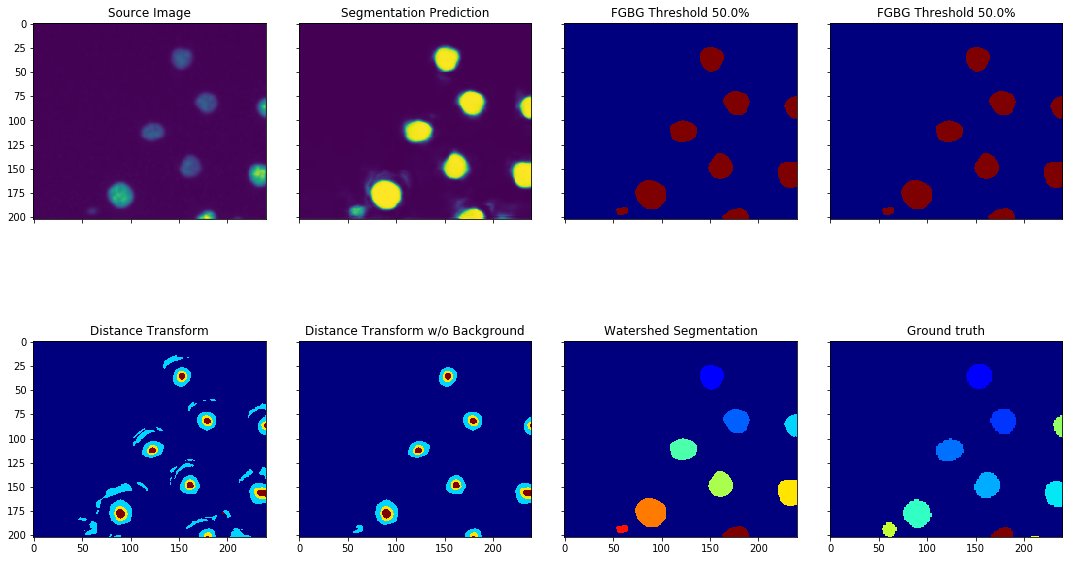

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

index = 0 #np.random.randint(low=0, high=1)
frame = 11 #np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)



fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.5
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.5 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Make Predictions on ISBI Data for Metrics

In [ ]:
###### FOR ISBI Challenge Datasets

# Define data to load (raw images from trk test files)  
RAW_BASE_DIR = '/data/data/ISBI_Tracking_Challenge/tracks'

raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'ISBI_HeLa_Chal_GT.trks')
raw_trks_MSC  = os.path.join(RAW_BASE_DIR, 'ISBI_MSC_resized_Chal_GT_normalized.trks')
raw_trks_U373 = os.path.join(RAW_BASE_DIR, 'ISBI_U373_Chal_GT.trks')

#raw_trks_files = [raw_trks_HeLa, raw_trks_MSC, raw_trks_U373]
raw_trks_files = [raw_trks_HeLa]

# Define where segmentations will be saved
SEG_BASE_DIR = '/data/track_data/Final_Benchmarks/ISBI_DC_SEG/Watershed/HeLa_segmentations'
                             
DC_seg_HeLa  = os.path.join(SEG_BASE_DIR, 'HeLa/')
DC_seg_MSC   = os.path.join(SEG_BASE_DIR, 'MSC/')
DC_seg_U373  = os.path.join(SEG_BASE_DIR, 'U373/')

#DC_seg_folders = [DC_seg_HeLa, DC_seg_MSC, DC_seg_U373]
DC_seg_folders = [DC_seg_HeLa]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [ ]:
# Instantiate new models for any image size

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=(None, None, 1),
    last_only=False)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')


watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=(None, None, 1))

watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

In [ ]:
# Run Predict for metric information only

CELL_TYPE_NAME = ['HeLa']
threshold = 0.9

from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import tarfile
import pathlib
import tempfile
import json
import pandas as pd
from io import BytesIO


def load_trks(filename):
    """Load a trk/trks file.

    Args:
        trks_file: full path to the file including .trk/.trks

    Returns:
        A dictionary with raw, tracked, and lineage data
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

    return {'X': raw, 'y': tracked}


Lstats_AllDatasets = []

# Go through each Dataset
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    raw, tracked = trks['X'], trks['y']
    
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
                
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):

        Lstats = []
        # Predict on the raw data
        for frame_num, frame in enumerate(movie):
            
            image = np.expand_dims(frame, axis=0)
             
            test_image = watershed_model.predict(image)[-1]
            test_image_fgbg = fgbg_model.predict(image)[-1]

            # Postprocessing
            # Collapse predictions into semantic segmentation mask        
            max_image = np.argmax(test_image, axis=-1)
            argmax_image = np.expand_dims(max_image, axis=-1)
        
            # threshold the foreground/background
            # and remove background from watershed transform
            fg_thresh = test_image_fgbg[..., 1] > threshold

            fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
            argmax_image_post_fgbg = argmax_image * fg_thresh
        
            # Apply watershed method with the distance transform as seed
            image = fg_thresh[..., 0]
            distance = argmax_image_post_fgbg[..., 0]

            local_maxi = peak_local_max(test_image[..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)

            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_image = np.expand_dims(segments, axis=-1)
            
            # Remove small objects from GT for comparison
            small_objects_threshold=50
            GT_image = trks['y'][batch_num, frame_num, :, :, :]
            GT_image = np.expand_dims(GT_image, axis=0)
            GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)
            
            # Accuracy from metrics package
            filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
            
            m = metrics.Metrics(model_name = filename)
            m.calc_object_stats(GT_image, watershed_image)
            
            # Store results
            y_new[batch_num, frame_num, :, :, :] = watershed_image

            Lstats.append(m.stats)
            
    # Save results of this batch before moving on to the next
    filename = os.path.join(DC_seg_folders[set_num], 'all_batches.trks')
    filename = pathlib.Path(filename)

    with tarfile.open(str(filename), 'w') as trks:
        with tempfile.NamedTemporaryFile() as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            trks.add(raw_file.name, 'raw.npy')

        with tempfile.NamedTemporaryFile() as tracked_file:
            np.save(tracked_file, y_new)
            tracked_file.flush()
            trks.add(tracked_file.name, 'tracked.npy')
                
        
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)
    
    
#df_HeLa   = pd.concat(Lstats_AllDatasets[0])
df_HeLa = pd.concat([pd.concat(Lstats_AllDatasets[0][0]) , pd.concat(Lstats_AllDatasets[0][1])])


In [ ]:
CELL_TYPE_DF = [df_HeLa]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)